# Aquidneck Island Traffic Model
The Aquidneck Island Traffic Model (AITM) is a microsimulation model built with [SUMO](https://sumo.dlr.de/docs/index.html).  The model is comprised of two parts: a network model refined from [OpenStreetMap data](https://www.openstreetmap.org/copyright), and traffic demand derived from [Rhode Island State Highway Model (RISM)](http://www.planning.ri.gov/planning-areas/transportation/travel-demand-model.php) data.

In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import contextily as cx

In [11]:
import sys, os
# add sumo tools to path to continue imports
if "SUMO_HOME" in os.environ:
	sumotools = os.path.join(os.environ['SUMO_HOME'], 'tools')
	sys.path.append(sumotools)
else:
	sys.exit("please declare environment variable 'SUMO_HOME'")

import sumolib

# add local sumo_processing directory
sumoproc = os.path.join(os.getcwd(), '../../data-processing/')
sys.path.append(sumoproc)

import sumo_processing

## Network Model
The Aquidneck Island Traffic Model uses the base Aquidneck Island SUMO network model built using tools included with the SUMO package.  First, OpenStreetMap data was downloaded using the overpass api.  The OpenStreetMap datafile was transformed to a SUMO network file using the `NETCONVERT` tool.  The NETCONVERT configuration file is `netconvert_configuration.netc.cfg` in the project repository.  Once converted to the SUMO network format, the `NETEDIT` tool was used to manually refine the network, including lanes, intersections, and traffic signals.

In [12]:
net = sumolib.net.readNet('../aquidneck_island.net.xml')

In [13]:
# convert sumolib Net to a GeoDataFrame for further processing
net_edges = sumo_processing.net_edges_to_geodataframe(net)
net_edges.index = net_edges['edge_id']
net_edges.index.name = 'id'

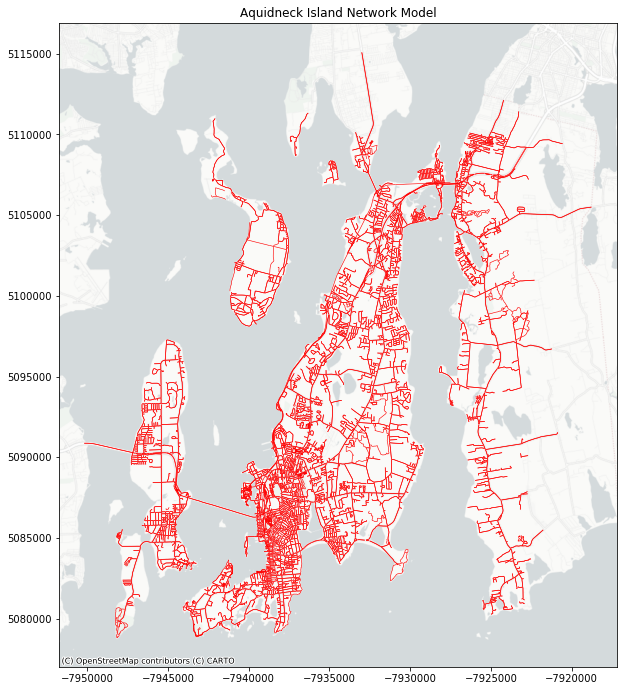

In [40]:
ax = net_edges.to_crs(epsg=3857).plot(figsize=[10,15], color='red', linewidth=0.6)
ax.set_title('Aquidneck Island Network Model')
cx.add_basemap(ax, url=cx.providers.CartoDB.PositronNoLabels)
plt.show()

### AITM Network Features
Some features were added to the Aquidneck Island network model to 1) improve the realism of traffic features and 2) improve execution of the simulation.
#### Naval Station Newport Gates
* Router weights - router edge weighting added to all base entrances to reflect the restricted access on the base and discourage cut through traffic
* Gate closures - road closure rerouting devices are placed in the vicinity to send traffic around gates during hours they are closed.
* Gate processing speeds - reduced speeds at the gate entrances simulate the security processing time and allow queues to form during peak hours.

## Trips and User Assignment
### Trip Generation
The AITM uses origin/destination (OD) matrices from the RISM as inputs for trip generation using the SUMO `OD2TRIPS` program.  The OD matrices represent annual average daily traffic (AADT) counts between traffic analysis zones (TAZ); the method for developing them is described in RI State Planning Program [TP166](http://www.planning.ri.gov/documents/trans/travel/tp166.pdf).  Trips for OD pairs are randomly distributed across 24 hours in the simulation.  The distribution is weighted for each hour to account for hourly variability in travel, e.g. to represent morning and evening rush hours for work-based traffic.  
A specific trip is created by randomly selecting a pair of network edges within the source TAZ and destination TAZ. The edges within the TAZ are weighted to reflect actual land use, i.e. a road segment with no buildings has almost no weight within the TAZ, while an edge on a dense city block is weighted higher.

In [15]:
# load route and taz files
vroutes = pd.read_csv('../../aquidneck-model-datafiles/ai15/run0/ai_simulation_vehroutes.csv', sep=';').dropna(axis='columns', how='all')
ai_taz = gpd.read_file('../../../Datasets/RI State Traffic Model Data/Easy Data/Easy Data/RITAZ15_aquidneck_singlepart.shp').set_index('ID')

In [16]:
ai_taz['outbound'] = vroutes['vehicle_fromTaz'].value_counts()
ai_taz['inbound'] = vroutes['vehicle_toTaz'].value_counts()

C:\Anaconda3\envs\gis\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
C:\Anaconda3\envs\gis\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


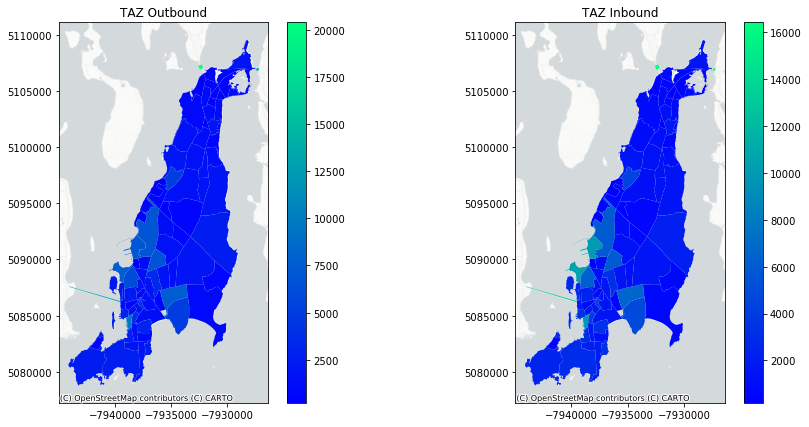

In [42]:
fig, axs = plt.subplots(1,2, figsize=[15,7])
ai_taz.to_crs(epsg=3857).plot('outbound', legend=True, cmap='winter', ax=axs[0])
ai_taz.to_crs(epsg=3857).plot('inbound', legend=True, cmap='winter', ax=axs[1])
axs[0].set_title('TAZ Outbound')
axs[1].set_title('TAZ Inbound')
cx.add_basemap(axs[0], url=cx.providers.CartoDB.PositronNoLabels)
cx.add_basemap(axs[1], url=cx.providers.CartoDB.PositronNoLabels)
plt.show()

### Routing
Routes are computed for the trips generated from the process above.  The `DUAROUTER` program is used to generate shortest-path routes on the network for each trip using the Djikstra algorithm.  These routes do not consider traffic on the network.  To account for local knowledge of traffic flows, 70% of the inserted vehicles are assigned a rerouting device and update their routes every 5 minutes based on current traffic conditions. Codeca et al. have validated this approach in their Luxembourg SUMO traffic scenario (2015).


-----
Codeca, Lara, Raphaël Frank, and Thomas Engel. "Luxembourg sumo traffic (lust) scenario: 24 hours of mobility for vehicular networking research." In 2015 IEEE Vehicular Networking Conference (VNC), pp. 1-8. IEEE, 2015.

## Model Validation
The **AI15** scenario uses 2015 RISM OD data to model an "average" day based on the AADT counts in the RISM.  This scenario is used to validate the AITM because it can be compared with traffic counts and other modeled data. The simulation was run 10 times with different random seeds to obtain statistically reasonable results for traffic metrics.

In [19]:
# load simulation run data  
# This would typically be the output sub-directory in the simulation directory - adjust folder names to match sumocfg files

data_folder = '../../aquidneck-model-datafiles/ai15/'

summary_data = pd.DataFrame()
tripinfo_data = pd.DataFrame()
# traffic_data = pd.DataFrame()
# emissions_data = pd.DataFrame()
edge_data = pd.DataFrame()

for run in range(0,10):
    run_folder = data_folder + 'run%s/' % str(run)
    
    # build summary dataframe
    summary = pd.read_csv(run_folder+'ai_simulation_summary.csv', sep=';')
    summary.index.name = 'step'
    summary['run'] = run
    summary_data = summary_data.append(summary, sort=False)
    
    # build tripinfos
    tripinfo = pd.read_csv(run_folder+'ai_simulation_tripinfo.csv', sep=';')
    tripinfo['run'] = run
    tripinfo_data = tripinfo_data.append(tripinfo, sort=False)
    print(run_folder)
    
    # traffic data
    traffic = pd.read_csv(run_folder+'hourly_edge_traffic_data.csv', sep=';')
    traffic['run'] = run
    traffic.dropna(how='all', axis=1, inplace=True)
    edge_data = edge_data.append(traffic, sort=False)

../../aquidneck-model-datafiles/ai15/run0/
../../aquidneck-model-datafiles/ai15/run1/
../../aquidneck-model-datafiles/ai15/run2/
../../aquidneck-model-datafiles/ai15/run3/
../../aquidneck-model-datafiles/ai15/run4/
../../aquidneck-model-datafiles/ai15/run5/
../../aquidneck-model-datafiles/ai15/run6/
../../aquidneck-model-datafiles/ai15/run7/
../../aquidneck-model-datafiles/ai15/run8/
../../aquidneck-model-datafiles/ai15/run9/


The hourly AI15 data is averaged across the 10 simulation runs to find the mean flows on each edge in each time interval.

In [20]:
edge_data_meaned = edge_data.groupby(['edge_id','interval_begin', 'interval_end'], as_index=False).mean()

In [21]:
# compute AADT for the simulation
net_counts = net_edges.merge(edge_data_meaned.groupby('edge_id', as_index=False)[['edge_entered', 'edge_left', 'edge_arrived','edge_departed']].sum(), on='edge_id')
pairwise_net = np.equal.outer(net_counts['from'], net_counts['to'])
pairs = []
for source_idx in range(0,len(net_counts)):
    for dest_idx in range(source_idx,len(net_counts)):
        pw_ident = pairwise_net[source_idx][dest_idx] and pairwise_net[dest_idx][source_idx]
        if pw_ident:
            pairs.append([net_counts['edge_id'].iloc[source_idx], net_counts['edge_id'].iloc[dest_idx]])

net_total = gpd.GeoDataFrame()
for src_edg, dest_edg in pairs:
    edg_gdf = net_counts[net_counts.edge_id.isin([src_edg, dest_edg])][['edge_entered', 'edge_left','edge_arrived','edge_departed','geometry']]
    tot = gpd.GeoDataFrame.from_records([(edg_gdf.edge_entered.sum(), edg_gdf.edge_left.sum(), edg_gdf.edge_arrived.sum(), edg_gdf.edge_departed.sum(), edg_gdf.geometry.unary_union)], columns=['edge_entered', 'edge_left', 'edge_arrived', 'edge_departed', 'geometry'])
    net_total = net_total.append(tot, ignore_index=True, sort=False)

C:\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: outer method for ufunc <ufunc 'equal'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
net_total.crs = net_edges.crs

Selecting paired edges has the effect of removing some one-way road segments and divided highways, see for example the bridges.  The plots below illustrate the difference between paired edge flows and single edge flows.  Obviously the traffic distribution is the same between the two plots, so the paired edge flows could be used for direct comparison with datasets that report bi-directional total AADT for two-way roads (like the Highway Performance Monitoring System (HPMS) below). The single edge flows are more useful for detailed analysis of the traffic behavior in the AITM. 

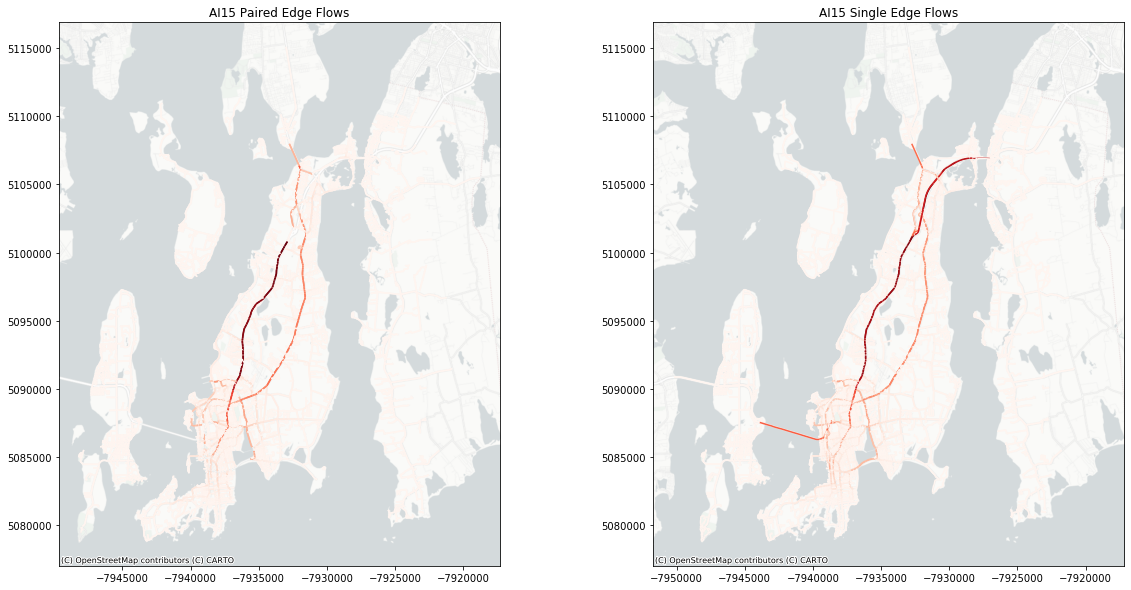

In [90]:
fig, axs = plt.subplots(1,2, figsize=[20,10])
net_total.to_crs(epsg=3857).plot('edge_left', cmap='Reds', ax=axs[0], linewidth=1.5)
axs[0].set_title('AI15 Paired Edge Flows')
net_counts.to_crs(epsg=3857).plot('edge_left', cmap='Reds', ax=axs[1], linewidth=1.5)
axs[1].set_title('AI15 Single Edge Flows')
cx.add_basemap(ax=axs[0], url=cx.providers.CartoDB.PositronNoLabels)
cx.add_basemap(ax=axs[1], url=cx.providers.CartoDB.PositronNoLabels)
plt.show()

### Highway Performance Monitoring System (HPMS) Comparison
The [HPMS dataset](https://data-usdot.opendata.arcgis.com/datasets/highway-performance-monitoring-system-nhs) includes annual average daily traffic (AADT) counts for major roads in the country.  Data for Rhode Island were extracted from the base dataset.

In [43]:
# load HPMS data
hpms15 = gpd.read_file('../../../Datasets/RI State Traffic Model Data/Easy Data/Easy Data/HPMS2015AI.shp').to_crs(net_edges.crs)
hpms16 = gpd.read_file('../../../Datasets/HPMS2016/RI-HPMS2016.shp').dropna(subset=['geometry']).to_crs(net_edges.crs)

The HPMS data represents each road as a single edge and reports the AADT for total traffic flow in both directions, while the AI network model represents each direction of travel as its own geometry.  To perform a valid comparison with the HPMS data, the network edge traffic counts need to be combined with their reverse-direction counterparts.  Reverse direction pairs are identified by selecting edges with swapped source and destination nodes, e.g. *edge(a,b)* and *edge(b,a)* will be paired and their individual traffic counts combined.

In [44]:
hpms16.geometry=hpms16.to_crs(net_edges.crs).buffer(5)
net_edges_with_hpms16 = gpd.sjoin(net_edges, hpms16, how="inner", op="intersects")
hpms16_calibration = net_edges_with_hpms16.merge(edge_data_meaned.groupby('edge_id', as_index=False)[['edge_entered','edge_left','edge_departed','edge_arrived']].sum(), on='edge_id').drop_duplicates(subset='edge_id')

In [46]:
# compute to-from pairwise comparison matrix
pairwise_net = np.equal.outer(hpms16_calibration['from'], hpms16_calibration['to'])
pairs = []
for source_idx in range(0, len(hpms16_calibration)):
    for dest_idx in range(source_idx, len(hpms16_calibration)):
        # find edges that are reverse identical
        pw_ident = pairwise_net[source_idx][dest_idx] and pairwise_net[dest_idx][source_idx]
        if pw_ident:
            pairs.append([hpms16_calibration['edge_id'].iloc[source_idx], hpms16_calibration['edge_id'].iloc[dest_idx]])

hpms16_cal_edges = gpd.GeoDataFrame()
# create reverse groupings in geodataframe
for src_edg, dest_edg in pairs:
    # sum edge_left values of each pair
    edg_gdf = hpms16_calibration[hpms16_calibration.edge_id.isin([src_edg, dest_edg])][['index_right', 'edge_left', 'aadt', 'geometry']]
    cal = gpd.GeoDataFrame.from_records([(edg_gdf.index_right.iloc[0], edg_gdf.edge_left.sum(), edg_gdf.aadt.iloc[0], edg_gdf.geometry.unary_union)], columns=['index_right','edge_left','hpms16_aadt','geometry'])
    hpms16_cal_edges = hpms16_cal_edges.append(cal, ignore_index=True, sort=False)

C:\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: outer method for ufunc <ufunc 'equal'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.
  


In [49]:
hpms16_cal_edges.crs = net_edges.crs

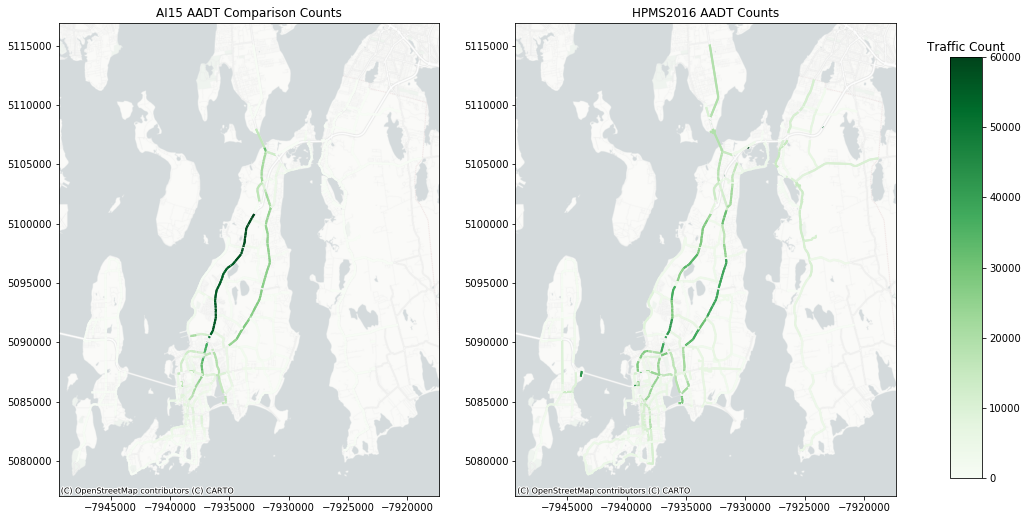

In [56]:
raw_cmap = plt.get_cmap('Greens')
cal_fig, axs = plt.subplots(1,2, figsize=[15,15])
axs[0].set_title('AI15 AADT Comparison Counts')
hpms16_cal_edges.to_crs(epsg=3857).plot('edge_left', ax=axs[0], cmap=raw_cmap, linewidth=2)
axs[1].set_title('HPMS2016 AADT Counts')
hpms16_cal_edges.to_crs(epsg=3857).plot('hpms16_aadt', ax=axs[1], cmap=raw_cmap, linewidth=2)

cx.add_basemap(ax=axs[0], url=cx.providers.CartoDB.PositronNoLabels)
cx.add_basemap(ax=axs[1], url=cx.providers.CartoDB.PositronNoLabels)

# add colorbar axes to the figure
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = cal_fig.add_axes([0.95, 0.3, 0.03, 0.39])   
cbax.set_title('Traffic Count')

sm = plt.cm.ScalarMappable(cmap=raw_cmap, \
                norm=plt.Normalize(vmin=0, vmax=60000))
# at this stage, 
# 'cbax' is just a blank axes, with un needed labels on x and y axes

# blank-out the array of the scalar mappable 'sm'
sm._A = []
# draw colorbar into 'cbax'
cal_fig.colorbar(sm, cax=cbax, format="%d")
plt.show()

The side-by-side comparison of the AI15 model and HPMS2016 dataset shows similar traffic flows on the island, with a bulk of the traffic traveling north-south along RT114 (West Main Rd) and RT138 (East Main Rd).  The HPMS2016 data has traffic counts beyond Aquidneck Island, while the AI15 model stops at the bridges.  A notable difference between the two datasets is the high traffic along RT114 in the AI15 model, where the HPMS2016 data shows more evenly distributed flow between RT114 and RT138.  The net difference between the datasets is plotted in the following figure.

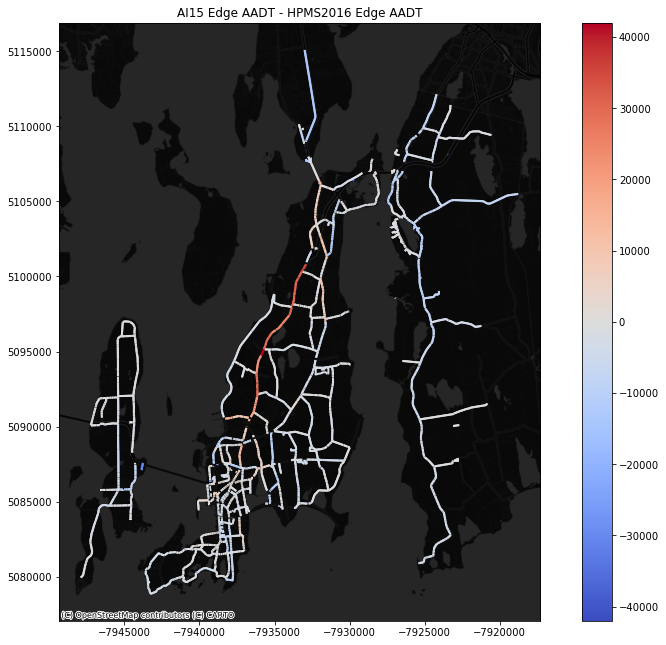

In [55]:
fig, ax = plt.subplots(1,1, figsize=[15,11])
gpd.GeoDataFrame(data = hpms16_cal_edges['edge_left'] - hpms16_cal_edges['hpms16_aadt'], geometry=hpms16_cal_edges.geometry, columns=['difference']).to_crs(epsg=3857).plot('difference', ax=ax, cmap='coolwarm', vmin=-42000, vmax=42000, legend=True, linewidth=2)
ax.set_title('AI15 Edge AADT - HPMS2016 Edge AADT')
cx.add_basemap(ax=ax, url=cx.providers.CartoDB.DarkMatterNoLabels)
plt.show()

This comparison can be visualized with a pairwise plot of AI15 and HPMS2016 traffic counts by edge.  A perfect fit would have all points along the line *y=x*.  This plot will show some expected error for roads off the island where the AI15 scenario did not include any traffic.

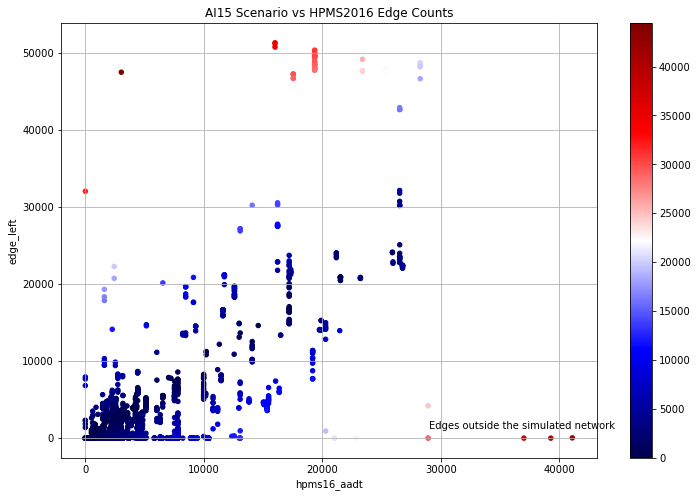

In [92]:
fig, ax = plt.subplots(1,1, figsize=[12,8])
hpms16_cal_edges[['edge_left', 'hpms16_aadt']].plot.scatter('hpms16_aadt', 'edge_left', ax=ax, grid=True, cmap='seismic', c=np.abs(hpms16_cal_edges['edge_left']-hpms16_cal_edges['hpms16_aadt']))
ax.set_title('AI15 Scenario vs HPMS2016 Edge Counts')
ax.text(29000, 1200, 'Edges outside the simulated network')
plt.show()

### Bridge Count Comparison
Hourly and seasonal traffic count data for the bridges onto Aquidneck Island were made available for this project. The bridges are major sources and sinks for traffic into the network. Comparison with the simulated scenarion helps validate the hourly traffic distribution in the model.

#### Hourly Comparison

In [58]:
# get data for bridge edges
sakonnet_model = edge_data.groupby('edge_id').get_group('92367190').groupby('interval_begin')['edge_entered'].mean() + edge_data.groupby('edge_id').get_group('652025236').groupby('interval_begin')['edge_left'].mean()
pell_model = edge_data.groupby('edge_id').get_group('19354939').groupby('interval_begin')['edge_entered'].mean() + edge_data.groupby('edge_id').get_group('71476104').groupby('interval_begin')['edge_left'].mean()
mthope_model = edge_data.groupby('edge_id').get_group('-92372403').groupby('interval_begin')['edge_entered'].mean() + edge_data.groupby('edge_id').get_group('92372403').groupby('interval_begin')['edge_left'].mean()

In [59]:
# read bridge count datafiles
sakonnet_count = pd.read_csv('../../../Datasets/RI State Traffic Model Data/sakonnet_counts.csv').dropna()
sakonnet_count.index = sakonnet_model.index[:-1]
jamestown_count = pd.read_csv('../../../Datasets/RI State Traffic Model Data/jamestown_counts.csv').dropna()
jamestown_count.index = pell_model.index[:-1]
mthope_count = pd.read_csv('../../../Datasets/RI State Traffic Model Data/mthope_counts.csv').dropna(how='all',axis=1).dropna(axis=0)
mthope_count.index = mthope_model.index[:-1]

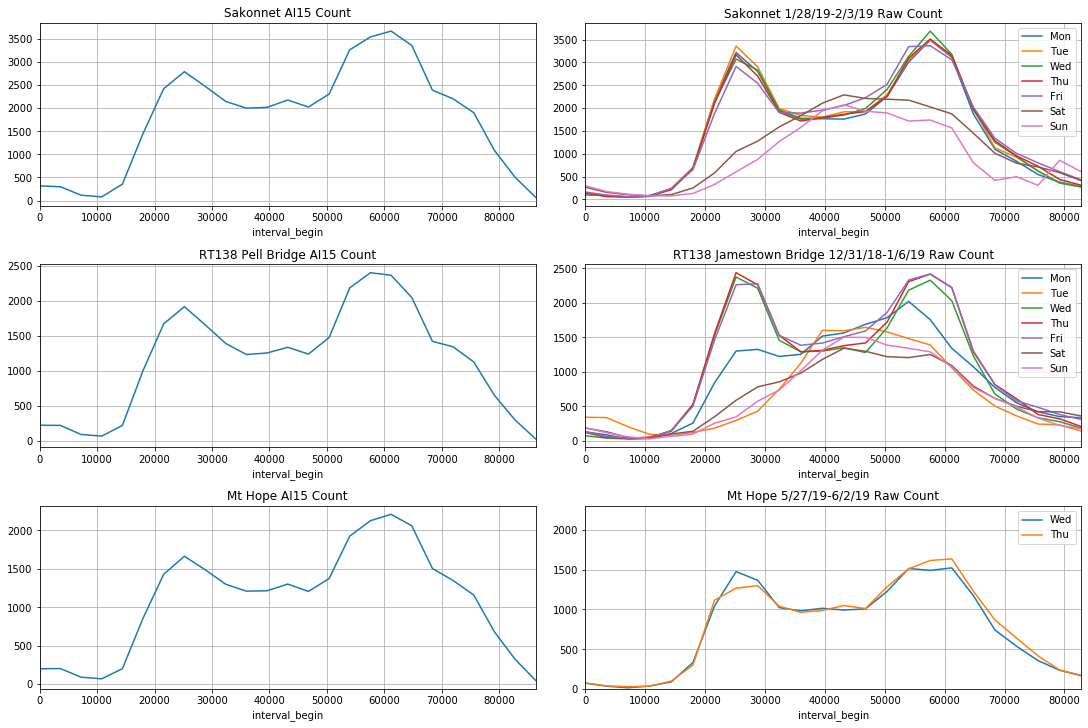

In [93]:
# plot bridge count comparisons
fig, axs = plt.subplots(3,2, figsize=[15,10], constrained_layout=True)
sakonnet_model.plot(ax=axs[0][0], grid=True)
sakonnet_count.plot(ax=axs[0][1], grid=True)
pell_model.plot(ax=axs[1][0], grid=True)
jamestown_count.plot(ax=axs[1][1], grid=True)
mthope_model.plot(ax=axs[2][0], grid=True)
mthope_count.plot(ax=axs[2][1], grid=True)

axs[0][0].set_title('Sakonnet AI15 Count')
axs[0][1].set_title('Sakonnet 1/28/19-2/3/19 Raw Count')
axs[1][0].set_title('RT138 Pell Bridge AI15 Count')
axs[1][1].set_title('RT138 Jamestown Bridge 12/31/18-1/6/19 Raw Count')
axs[2][0].set_title('Mt Hope AI15 Count')
axs[2][1].set_title('Mt Hope 5/27/19-6/2/19 Raw Count')
axs[2][1].set_ylim(0,2300)

plt.show()

Hourly traffic counts at the three bridges compared to the hourly model data show that the time distribution of trips in the scenario are realistic.  The Mt Hope bridge traffic counts, although limited, are much lower than the AI15 counts.  The off-island aggregation at the bridge may overestimate the number of trips that use the Mt Hope bridge for points outside Bristol County; it is more likely that drivers take RT24 because of the higher speeds and direct connection to Interstate 195 in Massachusetts.

The relative time distribution of traffic at each bridge also matches the general hourly network traffic distribution in the simulation.

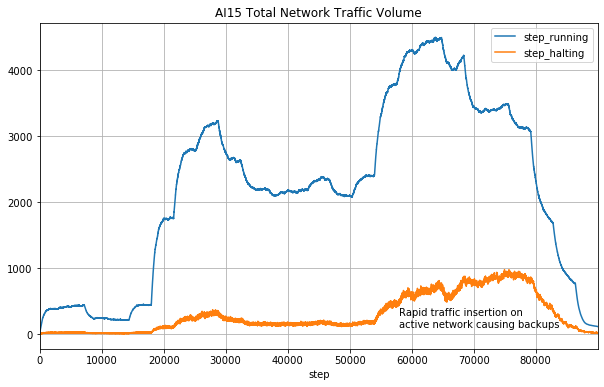

In [61]:
summary_data.groupby('step')[['step_running', 'step_halting']].mean().plot(title='AI15 Total Network Traffic Volume', figsize=[10,6], grid=True)
plt.text(58000,100,'Rapid traffic insertion on \nactive network causing backups')
plt.show()

#### Monthly Counts
Seasonal average counts were available for the Sakonnet River Bridge and Jamestown RT138.  These provide limited insight into the monthly variability at two of the network entrance points.

In [62]:
jamestown_month_data = pd.read_csv('../../../Datasets/RI State Traffic Model Data/jamestown_monthly.csv', index_col='Month', usecols=['Month','Average'])
sakonnet_month_data = pd.read_csv('../../../Datasets/RI State Traffic Model Data/sakonnet_monthly.csv', index_col='Month', usecols=['Month','Average'])

In [78]:
# clean invalid datapoint
jamestown_month_data.loc['Oct'] = np.NaN

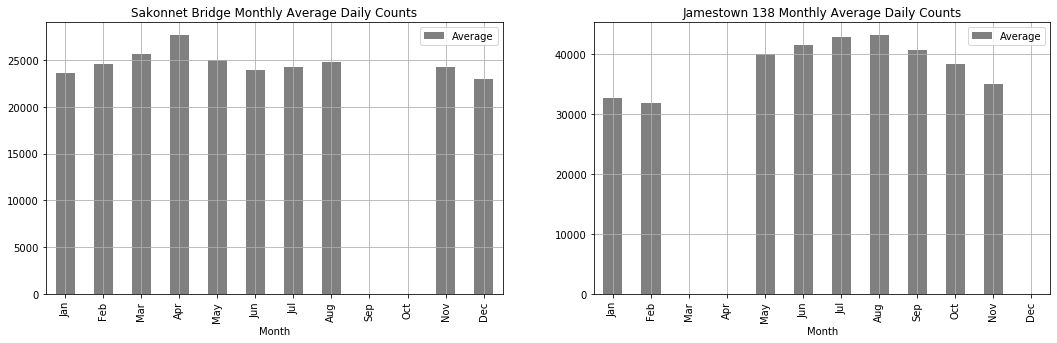

In [79]:
fig, axs = plt.subplots(1,2, figsize=[18,5])
jamestown_month_data.plot.bar(ax=axs[0], color='grey', grid=True)
sakonnet_month_data.plot.bar(ax=axs[1], color='grey', grid=True)
axs[1].set_title('Jamestown 138 Monthly Average Daily Counts')
axs[0].set_title('Sakonnet Bridge Monthly Average Daily Counts')
plt.show()

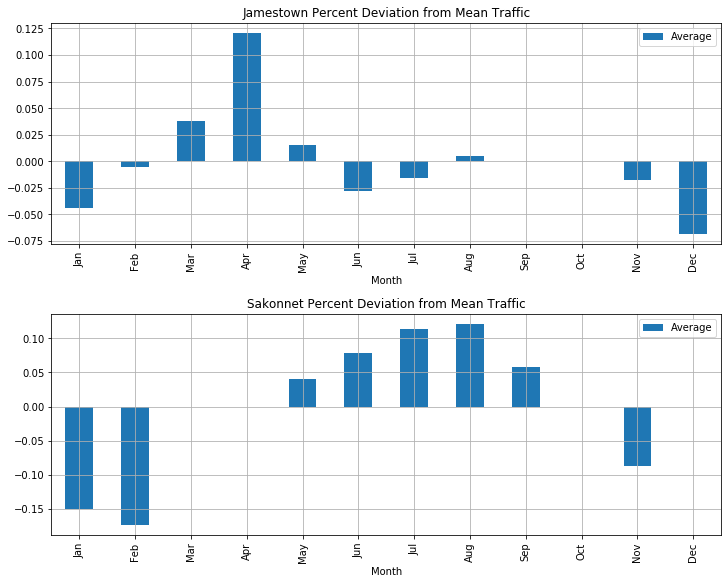

In [88]:
fix, axs = plt.subplots(2,1, figsize=[10,8], constrained_layout=True)
(jamestown_month_data/jamestown_month_data.mean()-1).plot.bar(ax=axs[0], grid=True)
axs[0].set_title('Jamestown Percent Deviation from Mean Traffic')
(sakonnet_month_data/sakonnet_month_data.mean()-1).plot.bar(ax=axs[1], grid=True)
axs[1].set_title('Sakonnet Percent Deviation from Mean Traffic')
plt.show()

Interestingly, the Jamestown monthly averages show slightly lower counts for summer months.  At face value, this is counterintuitive because of the significant summer tourism in Newport from points south, as well as numerous special events (e.g. Folk and Jazz Festivals) in July and August attracting off-island traffic.  The large deviation in April is likewise unexpected, as it is before the typical tourist season and there are not typically many large events in Newport during this month.

In [91]:
print('AI TAZ Pell Bridge total trip count: ', ai_taz.loc[1].inbound + ai_taz.loc[1].outbound)
print('AI TAZ Mt Hope Bridge total trip count: ', ai_taz.loc[2].inbound + ai_taz.loc[2].outbound)
print('AI TAX Sakonnet River Bridge total trip count: ', ai_taz.loc[3].inbound + ai_taz.loc[3].outbound)

AI TAZ Pell Bridge total trip count:  26576.0
AI TAZ Mt Hope Bridge total trip count:  29508.0
AI TAX Sakonnet River Bridge total trip count:  36734.0


## Validation Conclusion
The AI15 scenario has a relatively large difference with the HPMS2016 dat along RT114. Analysis of traffic over the bridges suggests that the temporal distribution of trips in the simulation are not significantly different from what could be expected on a weekday. Simulation trips to or from the Mt Hope Bridge appear to exceed raw traffic counts; this could be contributing to the discrepancy on RT114.  Seasonal distribution data on two of the external connections to the network show over 20% variation over the course of the year, with different patterns on each bridge. 
Factors to be investigated:
* An unidentified network flow obstruction on RT138 could be shifting more traffic down RT114 during the routing step.
* Trip counts are based on AADT.  Aquidneck Island has a very seasonal traffic pattern, so the network behavior at a microsimulation level may be overwhelmed on an annualized 'average' day, which never occurs in reality.
* Edges within TAZs may not be weighted accurately enough to distribute routes more realistically.
* Source OD data does not appear to factor in heavy seasonal or weekly effects, which may be leading to more trips within the island.
* Off-island trips may not be accurately balanced.